In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import cv2
from plotting import imshow


In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
class CustomDataset(Dataset):
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames # image name
        self.images_data = images_data # image data
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Creating image from the dataset
        img_data = self.images_data[idx]
        img = np.array(img_data, dtype=np.uint8)

        R_channel = img[0:1024].reshape(32, 32, 1)
        G_channel = img[1024:2048].reshape(32, 32, 1)
        B_channel = img[2048:].reshape(32, 32, 1)

        image = np.concatenate([R_channel,G_channel,B_channel], axis = 2)
    
        if self.transform:
            image = self.transform(image)

        return image, self.filenames[idx]

# Normalization and transforming to a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
train_set = unpickle('tobeignored/train')

images_data = train_set[b'data']

filenames = [f.decode('utf-8') for f in train_set[b'filenames']]

dataset = CustomDataset(filenames=filenames, images_data=images_data, transform=transform)
train_loader = DataLoader(dataset, batch_size=8, shuffle = False)

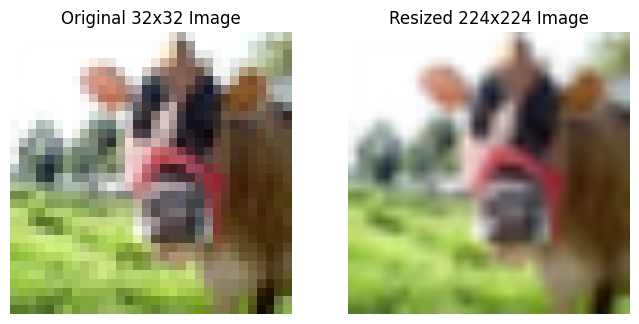

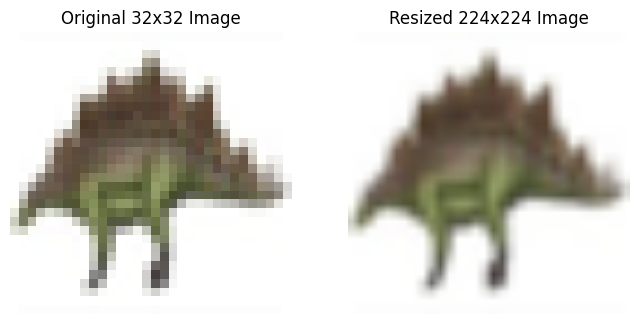

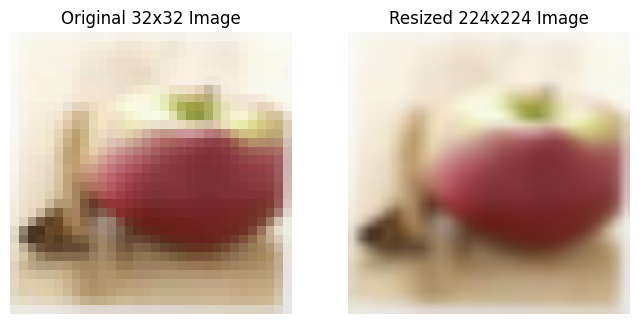

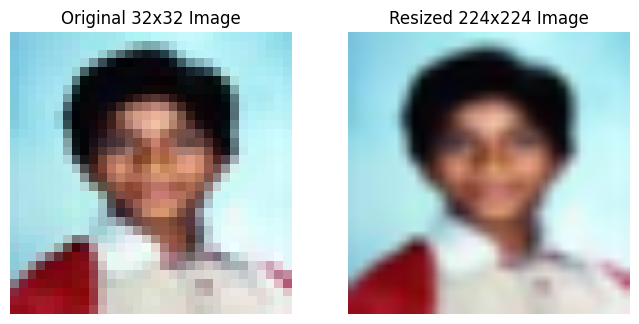

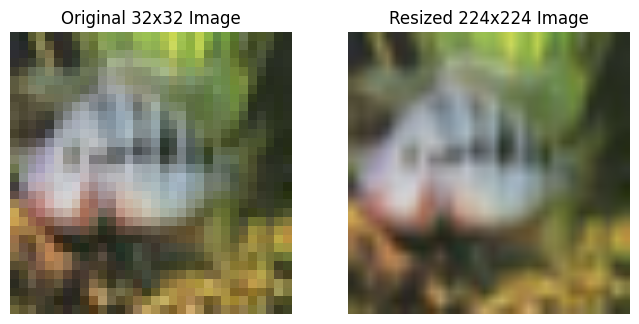

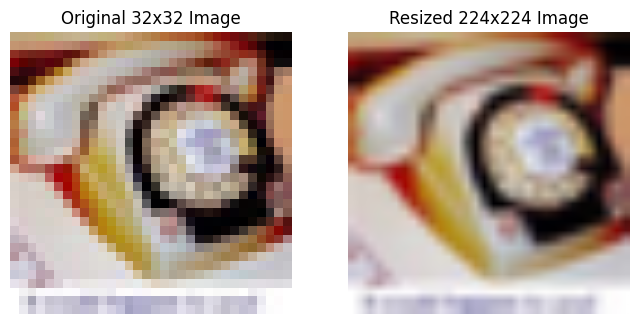

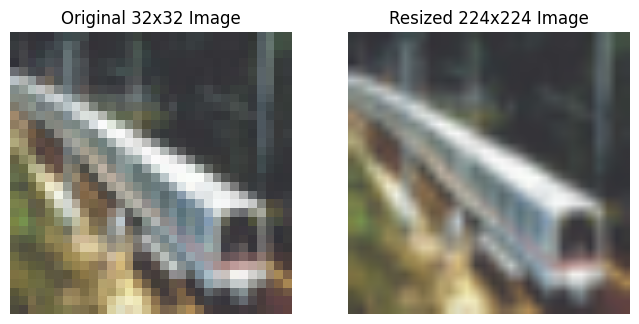

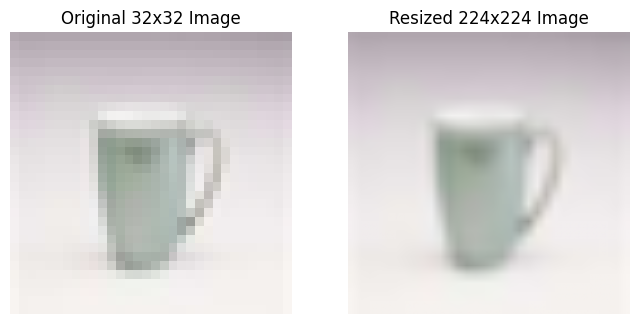

In [8]:
for batch in train_loader:
    image_tensor, filename = batch  # Extract data from the batch
    for idx, image_rgb in enumerate(image_tensor):
        resized_img = F.interpolate(image_rgb.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False).squeeze(0)

        # Convert to NumPy for visualization
        resized_img_numpy = resized_img.permute(1, 2, 0).cpu().numpy()

        # Plot the original and resized images
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        ax[0].imshow(image_rgb.permute(1, 2, 0).cpu().numpy())
        ax[0].set_title("Original 32x32 Image")
        ax[0].axis("off")

        ax[1].imshow(resized_img_numpy)
        ax[1].set_title("Resized 224x224 Image")
        ax[1].axis("off")

        plt.show()



        
    break

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class ColorizationUNet(nn.Module):
    def __init__(self):
        super(ColorizationUNet, self).__init__()
        
        # Load MobileNetV2 and modify the first convolution layer
        mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        
        # Sostituiamo il primo livello con una convoluzione personalizzata
        self.initial_conv = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.encoder = mobilenet.features[1:]  # Rimuoviamo il primo blocco di downsampling

        # Decoder per ricostruire l'immagine
        self.upconv1 = nn.ConvTranspose2d(1280, 512, kernel_size=4, stride=2, padding=1)  # 4x4 -> 8x8
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)  # 8x8 -> 16x16
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # 16x16 -> 32x32
        self.final_conv = nn.Conv2d(128, 2, kernel_size=3, padding=1)  # Output AB channels

    def forward(self, x):
        x = self.initial_conv(x)  # Adattiamo i canali di input
        x = self.encoder(x)
        x = F.relu(self.upconv1(x))
        x = F.relu(self.upconv2(x))
        x = F.relu(self.upconv3(x))
        x = torch.tanh(self.final_conv(x))  # Output in range [-1,1] per i canali AB
        return x

# Funzione di preprocessing: converte un'immagine in scala di grigi in un input RGB
def preprocess_input(y_channel):
    return y_channel.repeat(1, 3, 1, 1)  # Convertiamo l'immagine da 1 canale a 3 canali

# Test del modello
model = ColorizationUNet()

# Dummy input: immagine in scala di grigi 32x32
dummy_input = torch.randn(1, 1, 32, 32)
y_rgb = preprocess_input(dummy_input)  # Convertiamo in 3 canali
output = model(y_rgb)

print("Output shape:", output.shape)  # Deve essere (1, 2, 32, 32)



Output shape: torch.Size([1, 2, 16, 16])
